In [1]:
# import necessary libraries
import os, random, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
def get_device():
    if torch.cuda.is_available(): return torch.device("cuda")
    return torch.device("cpu")

In [4]:
# CIFAR10 data
def get_cifar10_loaders(batch_train=128, batch_test=256, data_dir="./data"):
    mean=(0.4914,0.4822,0.4465); std=(0.2023,0.1994,0.2010) # values obtained from running previous code for HW_1_2
    tf = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    train = torchvision.datasets.CIFAR10(root=data_dir, train=True,  download=True, transform=tf)
    test  = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=tf)
    train_loader = DataLoader(train, batch_size=batch_train, shuffle=True,  num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test,  batch_size=batch_test,  shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader

In [5]:
# CNN model 
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64,64,3,padding=1),   nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64x16x16
            nn.Conv2d(64,128,3,padding=1),  nn.ReLU(inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 128x8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
    def forward(self,x): return self.classifier(self.features(x))

In [6]:
# Model training and testing
def train_epochs(model, train_loader, epochs=10, lr=1e-3, weight_decay=0.0, device=None):
    device = device or get_device()
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
    return model

@torch.no_grad()
def evaluate(model, loader, device=None):
    device = device or get_device()
    model.eval().to(device)
    loss_fn = nn.CrossEntropyLoss()
    tot_loss, tot, correct = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        tot_loss += loss.item() * xb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss / tot, correct / tot

In [7]:
def interpolate_models(model1: nn.Module, model2: nn.Module, alpha: float) -> nn.Module:
    """Return a new model whose parameters are (1-alpha)*theta1 + alpha*theta2."""
    m_new = CNN()  # same architecture
    sd1 = model1.state_dict()
    sd2 = model2.state_dict()
    sd_new = {}
    for k in sd1.keys():
        sd_new[k] = (1.0 - alpha) * sd1[k] + alpha * sd2[k]
    m_new.load_state_dict(sd_new, strict=True)
    return m_new

In [8]:
def line_eval(model1, model2, alphas, train_loader, test_loader, device=None):
    """Evaluate train/test loss & accuracy for interpolated models across alphas."""
    device = device or get_device()
    train_losses, test_losses = [], []
    train_accs,   test_accs   = [], []
    for a in alphas:
        m = interpolate_models(model1, model2, a).to(device)
        tr_loss, tr_acc = evaluate(m, train_loader, device)
        te_loss, te_acc = evaluate(m, test_loader,  device)
        train_losses.append(tr_loss); train_accs.append(tr_acc)
        test_losses.append(te_loss);  test_accs.append(te_acc)
    return train_losses, test_losses, train_accs, test_accs

In [9]:
# Plots
def plot_loss_and_acc(alphas, tr_loss, te_loss, tr_acc, te_acc, title, out=None):
    fig, ax1 = plt.subplots(figsize=(8.5,5.2))
    ax1.plot(alphas, tr_loss, label="train loss", linewidth=1.5, color="tab:blue")
    ax1.plot(alphas, te_loss, label="test loss",  linewidth=1.5, color="tab:blue", linestyle="--")
    ax1.set_xlabel("alpha"); ax1.set_ylabel("cross-entropy", color="tab:blue")
    ax1.grid(True, linewidth=0.3)
    ax2 = ax1.twinx()
    ax2.plot(alphas, tr_acc, label="train acc", linewidth=1.5, color="tab:red")
    ax2.plot(alphas, te_acc, label="test acc",  linewidth=1.5, color="tab:red", linestyle="--")
    ax2.set_ylabel("accuracy", color="tab:red")
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines+lines2, labels+labels2, loc="best")
    plt.title(title)
    plt.tight_layout()
    if out:
        os.makedirs(os.path.dirname(out), exist_ok=True)
        plt.savefig(out, dpi=180)
    plt.show(); plt.close()

In [10]:
def main(
    epochs1=20, epochs2=20,
    batch_train_1=64, batch_train_2=1024,   # different training approaches (batch sizes)
    lr1=1e-3, lr2=1e-4, # different learning rates for both models
    data_dir="./data",
    alphas=None,
    out_dir="HW_1-3_FlatVsGen_Part1"
):
    """
    Train two CNNs with different training settings, then evaluate the line interpolations.
    """
    set_seed(42)
    dev = get_device()
    os.makedirs(out_dir, exist_ok=True)

    if alphas is None:
        alphas = np.linspace(-1.0, 2.0, 61) 

    # Loaders for evaluation (use a consistent batch size)
    train_loader_1, test_loader   = get_cifar10_loaders(batch_train=batch_train_1, data_dir=data_dir)
    train_loader_2, _             = get_cifar10_loaders(batch_train=batch_train_2, data_dir=data_dir)

    # Train model m1
    m1 = CNN()
    m1 = train_epochs(m1, train_loader_1, epochs=epochs1, lr=lr1, device=dev)

    # Train model m2 
    m2 = CNN()
    m2 = train_epochs(m2, train_loader_2, epochs=epochs2, lr=lr2, device=dev)

    # Evaluate interpolations
    tr_loss, te_loss, tr_acc, te_acc = line_eval(m1, m2, alphas, train_loader_1, test_loader, device=dev)

    # Plot
    out_path = os.path.join(out_dir, "cifar_interpolation_loss_acc.png")
    plot_loss_and_acc(alphas, tr_loss, te_loss, tr_acc, te_acc,
                      title=f"CIFAR-10: model 1 vs model 2 (bs={batch_train_1} vs {batch_train_2})",
                      out=out_path)
    print("Saved:", out_path)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


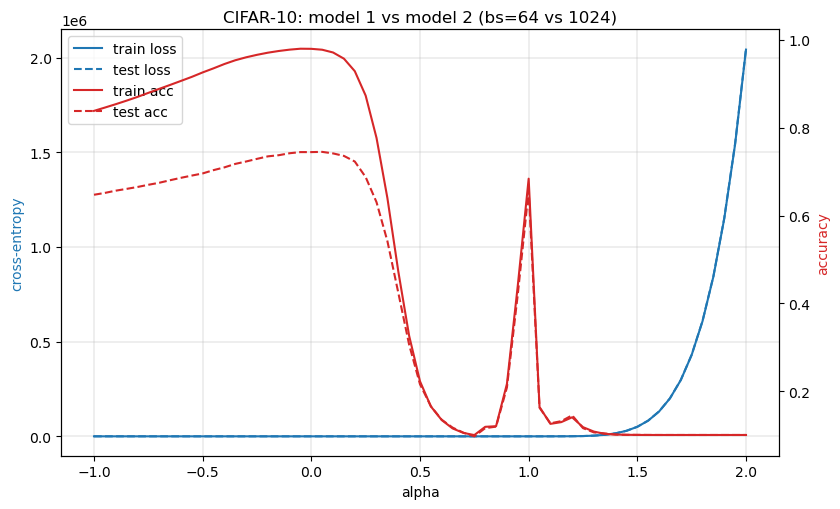

Saved: HW_1-3_FlatVsGen_Part1/cifar_interpolation_loss_acc.png


In [11]:
if __name__ == "__main__":
    main()